In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
#from nltk.corpus import stopwords
from nltk import word_tokenize
#STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import plotly.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

Using TensorFlow backend.


In [2]:
import re
import unicodedata

In [3]:
from imblearn.pipeline import Pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import balanced_accuracy_score

In [4]:
df=pd.read_csv('data/train.csv')

In [5]:
temp1=df[df['label_quality']=='unreliable']['category'].tolist()
temp2=df[df['label_quality']=='reliable']['category'].tolist()

cat_not_in_reliable=list(set(temp1) - set(temp2))
cat_count=df[(df['label_quality']=='reliable')|(df['category'].isin(cat_not_in_reliable))]['category'].value_counts()
cat_low_count=cat_count[cat_count<4000].index.tolist()
df=df[(df['label_quality']=='reliable')|(df['category'].isin(cat_not_in_reliable))|(df['category'].isin(cat_low_count))]
all_cat=df['category'].value_counts()
all_cat=all_cat[all_cat<=400].index.tolist()
df_portuguese_temp        = df[df['language']=='portuguese']
counts_portuguese         = df_portuguese_temp['category'].value_counts()
low_portuguese            =counts_portuguese[counts_portuguese<200]
df_portuguese=df[(df['language']=='portuguese')|\
              (~df['category'].isin(counts_portuguese.index))|\
              (df['category'].isin(all_cat))|\
              (df['category'].isin(low_portuguese.index))]

sampling_portuguese={}
counts_portuguese  = df_portuguese['category'].value_counts()
for cat in counts_portuguese.index:
    if counts_portuguese.loc[cat]>2200:
        sampling_portuguese[cat]=2200
    else:
        sampling_portuguese[cat]=counts_portuguese.loc[cat]

X_portuguese = df_portuguese['title']
y_portuguese = df_portuguese['category']

rus_portuguese = RandomUnderSampler(sampling_strategy=sampling_portuguese,random_state=42)
X_res_portuguese, y_res_portuguese = rus_portuguese.fit_resample(X_portuguese.values.reshape(-1, 1), y_portuguese)

#Portuguese
X_res_portuguese=pd.DataFrame(X_res_portuguese)
X_res_portuguese.columns=['title']
X_res_portuguese['title']=X_res_portuguese['title'].astype('str')
y_res_portuguese=pd.Series(y_res_portuguese)

In [6]:
def clean_text(text) :
    text=unicodedata.normalize('NFKD', str(text)).encode('ascii', errors='ignore').decode('utf-8')\
    .lower().replace(r'\\n','').replace(r'-',' ').replace(r'.','').strip()
    text = re.sub("[^a-zA-Z]", " ", str(text))
    #return " ".join(text.split())
    return " ".join([w for w in text.split() if len(w)>1])

In [7]:
X_res_portuguese['title']=X_res_portuguese['title'].apply(clean_text)

In [8]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each title.
MAX_SEQUENCE_LENGTH = 40
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_res_portuguese['title'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 241620 unique tokens.


In [9]:
X = tokenizer.texts_to_sequences(X_res_portuguese['title'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (3105468, 40)


In [10]:
y = pd.get_dummies(y_res_portuguese).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (3105468, 1588)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5, random_state = 42,)# stratify=y)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1552734, 40) (1552734, 1588)
(1552734, 40) (1552734, 1588)


In [12]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1588, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 100)           5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 40, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1588)              160388    
Total params: 5,240,788
Trainable params: 5,240,788
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
epochs = 7
batch_size = 64
history = model.fit(X_train, y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

e:\anaconda\envs\keras\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 1397460 samples, validate on 155274 samples
Epoch 1/7
1397460/1397460 [==============================] - 2088s 1ms/step - loss: 1.9866 - categorical_accuracy: 0.6491 - val_loss: 0.9348 - val_categorical_accuracy: 0.8125
Epoch 2/7
1397460/1397460 [==============================] - 2063s 1ms/step - loss: 0.9154 - categorical_accuracy: 0.8139 - val_loss: 0.8244 - val_categorical_accuracy: 0.8331
Epoch 3/7
1397460/1397460 [==============================] - 2134s 2ms/step - loss: 0.8012 - categorical_accuracy: 0.8316 - val_loss: 0.7931 - val_categorical_accuracy: 0.8389
Epoch 4/7
1397460/1397460 [==============================] - 3018s 2ms/step - loss: 0.7450 - categorical_accuracy: 0.8407 - val_loss: 0.7757 - val_categorical_accuracy: 0.8424
Epoch 5/7
1397460/1397460 [==============================] - 2647s 2ms/step - loss: 0.7102 - categorical_accuracy: 0.8464 - val_loss: 0.7673 - val_categorical_accuracy: 0.8448
Epoch 6/7
1397460/1397460 [==============================] - 2147s 

In [14]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1552734/1552734 [==============================] - 313s 202us/step
Test set
  Loss: 0.757
  Accuracy: 0.848


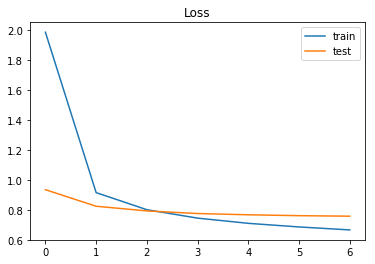

In [16]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

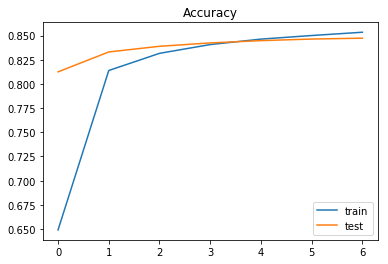

In [21]:
plt.title('Categorical Accuracy')
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='test')
plt.legend()
plt.show();

In [22]:
labels = pd.get_dummies(y_res_portuguese).columns

In [93]:
title = 'Te Rojo En Hebras   X 1 Kg Nacional Imperdible'
title_clean = clean_text(title)
seq = tokenizer.texts_to_sequences([title_clean])
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
print(labels[np.argmax(pred)])

TEA


In [23]:
model.save('models/LSTM_portuguese.h5')

# SUBMIT

In [24]:
df_test = pd.read_csv('data/test.csv')

In [25]:
df_pred_portuguese=df_test[df_test['language']=='portuguese']
df_pred_portuguese['title']=df_pred_portuguese['title'].apply(clean_text)

In [26]:
def prediction(title):
    seq = tokenizer.texts_to_sequences([title])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    return labels[np.argmax(pred)]

In [27]:
df_pred_portuguese['category'] = df_pred_portuguese['title'].apply(prediction)

In [28]:
df_pred_portuguese.head()

,id,title,language,category
0,0,kit maternidade bolsa mala baby bebe vinho men...,portuguese,DIAPER_BAGS
1,1,trocador de fraldas fisher price feminino rosa...,portuguese,BABY_DIAPERS
2,2,motor ventoinha fiat idea palio,portuguese,ENGINE_COOLING_FAN_MOTORS
3,3,amortecedor mola batente dir new civic,portuguese,AUTOMOTIVE_SHOCK_ABSORBER_BUMP_STOPS
4,4,cadeirinha de carro bebe princesa princess kgs,portuguese,BABY_CAR_SEATS


In [29]:
df_pred_portuguese.to_csv('submit/submit_lstm_portuguese_2.csv',index=False)